In [55]:
#%reset
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk
import numpy as np
import eli5

from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import cross_validate, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.utils import resample
from sklearn.inspection import permutation_importance
from scipy.stats import loguniform
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix
from eli5.sklearn import PermutationImportance
hfont = {'fontname':'Helvetica'}

## read data 
CIP_data = pd.read_csv("CIP_data_encode_prev.csv")
CIP_data_no_drop = pd.read_csv("CIP_data_encode_prev_not_dropped.csv")
print(CIP_data_no_drop.columns)

Index(['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'CLINIC', 'YEAR',
       'GENDERSP', 'Susceptible', 'MSM', 'MSMW', 'MSW', 'Oth/Unk/Missing',
       'REGION', 'Midwest', 'Northeast', 'Southeast', 'Southwest', 'West',
       'PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION'],
      dtype='object')


In [26]:
############# data

#nn_data 
best_features_by_year_nn = {2005: ['PREV_CLINIC', 'MSM', 'PREV_REGION', 'West', 'Southwest', 'Southeast', 'MSW', 'MSMW', 'Northeast'], 2006: ['DELTA_REGION', 'PREV_REGION', 'MSW', 'MSM', 'Northeast', 'Southwest', 'Midwest', 'Oth/Unk/Missing', 'MSMW'], 2007: ['PREV_REGION', 'West', 'Midwest', 'MSM', 'Southwest', 'MSW', 'Northeast', 'Southeast', 'PREV_CLINIC', 'DELTA_REGION', 'MSMW', 'Oth/Unk/Missing'], 2008: ['PREV_REGION', 'PREV_CLINIC', 'West', 'MSM', 'MSW', 'Midwest', 'Southwest', 'Southeast', 'MSMW', 'Northeast', 'Oth/Unk/Missing'], 2009: ['PREV_REGION', 'Southwest', 'West', 'PREV_CLINIC', 'Northeast', 'Southeast', 'MSM', 'MSW', 'Midwest', 'Oth/Unk/Missing', 'MSMW'], 2010: ['PREV_REGION', 'MSM', 'MSW', 'West', 'Southeast', 'MSMW', 'Northeast', 'Southwest', 'Midwest', 'PREV_CLINIC', 'DELTA_REGION', 'Oth/Unk/Missing']}
best_hyperparameters_by_year_nn = {2005: {'hidden_layer_sizes': 12, 'alpha': 0.2782559402207124}, 2006: {'hidden_layer_sizes': 12, 'alpha': 0.2782559402207124}, 2007: {'hidden_layer_sizes': 12, 'alpha': 0.2782559402207124}, 2008: {'hidden_layer_sizes': 12, 'alpha': 0.2782559402207124}, 2009: {'hidden_layer_sizes': 12, 'alpha': 0.2782559402207124}, 2010: {'hidden_layer_sizes': 12, 'alpha': 0.2782559402207124}}
ROC_by_year_nn = {2005: 0.6721866096866097, 2006: 0.7203611517707105, 2007: 0.7182824648636995, 2008: 0.6828011317704124, 2009: 0.6694464181095197, 2010: 0.6389558232931727}
##lr_data 

best_hyperparameters_by_year_lr = {2005: {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.74}, 2006: {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.91}, 2007: {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.91}, 2008: {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.67}, 2009: {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.67}, 2010: {'solver': 'liblinear', 'penalty': 'l2', 'C': 0.84}}
best_features_by_year_lr = {2005: ['MSW', 'MSM', 'West', 'PREV_CLINIC', 'Southeast', 'Northeast'], 2006: ['PREV_CLINIC', 'MSW', 'Southwest', 'Southeast', 'MSM'], 2007: ['MSW', 'MSM', 'PREV_REGION', 'PREV_CLINIC', 'West', 'Oth/Unk/Missing', 'Southwest', 'MSMW', 'Northeast', 'DELTA_REGION'], 2008: ['PREV_CLINIC', 'MSM', 'MSW', 'Southwest', 'Northeast', 'DELTA_REGION', 'MSMW'], 2009: ['PREV_REGION', 'MSW', 'MSM', 'DELTA_REGION', 'PREV_CLINIC', 'Oth/Unk/Missing', 'Southwest', 'MSMW', 'Northeast'], 2010: ['MSW', 'MSM', 'Oth/Unk/Missing', 'MSMW', 'Southwest']}
ROC_by_year_lr = {2005: 0.741191107531469, 2006: 0.7694780206421525, 2007: 0.722145250867408, 2008: 0.7009698281482254, 2009: 0.6675871839843078, 2010: 0.6469372553684413}

##rf_paper 
best_hyperparameters_by_year_rf = {2005: {'n_estimators': 163, 'min_samples_split': 5, 'min_samples_leaf': 14, 'max_depth': 81}, 2006: {'n_estimators': 163, 'min_samples_split': 5, 'min_samples_leaf': 14, 'max_depth': 81}, 2007: {'n_estimators': 163, 'min_samples_split': 5, 'min_samples_leaf': 14, 'max_depth': 81}, 2008: {'n_estimators': 163, 'min_samples_split': 5, 'min_samples_leaf': 14, 'max_depth': 81}, 2009: {'n_estimators': 163, 'min_samples_split': 5, 'min_samples_leaf': 14, 'max_depth': 81}, 2010: {'n_estimators': 163, 'min_samples_split': 5, 'min_samples_leaf': 14, 'max_depth': 81}}
best_features_by_year_rf = {2005: ['PREV_CLINIC', 'MSW', 'MSM', 'PREV_REGION', 'DELTA_REGION', 'Midwest', 'MSMW'], 2006: ['MSW', 'PREV_CLINIC', 'MSM', 'PREV_REGION', 'MSMW', 'Oth/Unk/Missing', 'Southeast'], 2007: ['PREV_CLINIC', 'MSW', 'MSM', 'PREV_REGION', 'Southwest', 'MSMW'], 2008: ['MSW', 'PREV_CLINIC', 'MSM', 'Southeast', 'MSMW', 'Oth/Unk/Missing', 'West'], 2009: ['MSW', 'PREV_CLINIC', 'PREV_REGION', 'West', 'MSM', 'Southeast', 'Midwest', 'Northeast', 'MSMW'], 2010: ['MSW']}
ROC_by_year_rf = {2005: 0.7558760683760685, 2006: 0.7423020289564215, 2007: 0.6939215210683053, 2008: 0.6805780113177041, 2009: 0.6637346610608643, 2010: 0.6464859437751003}


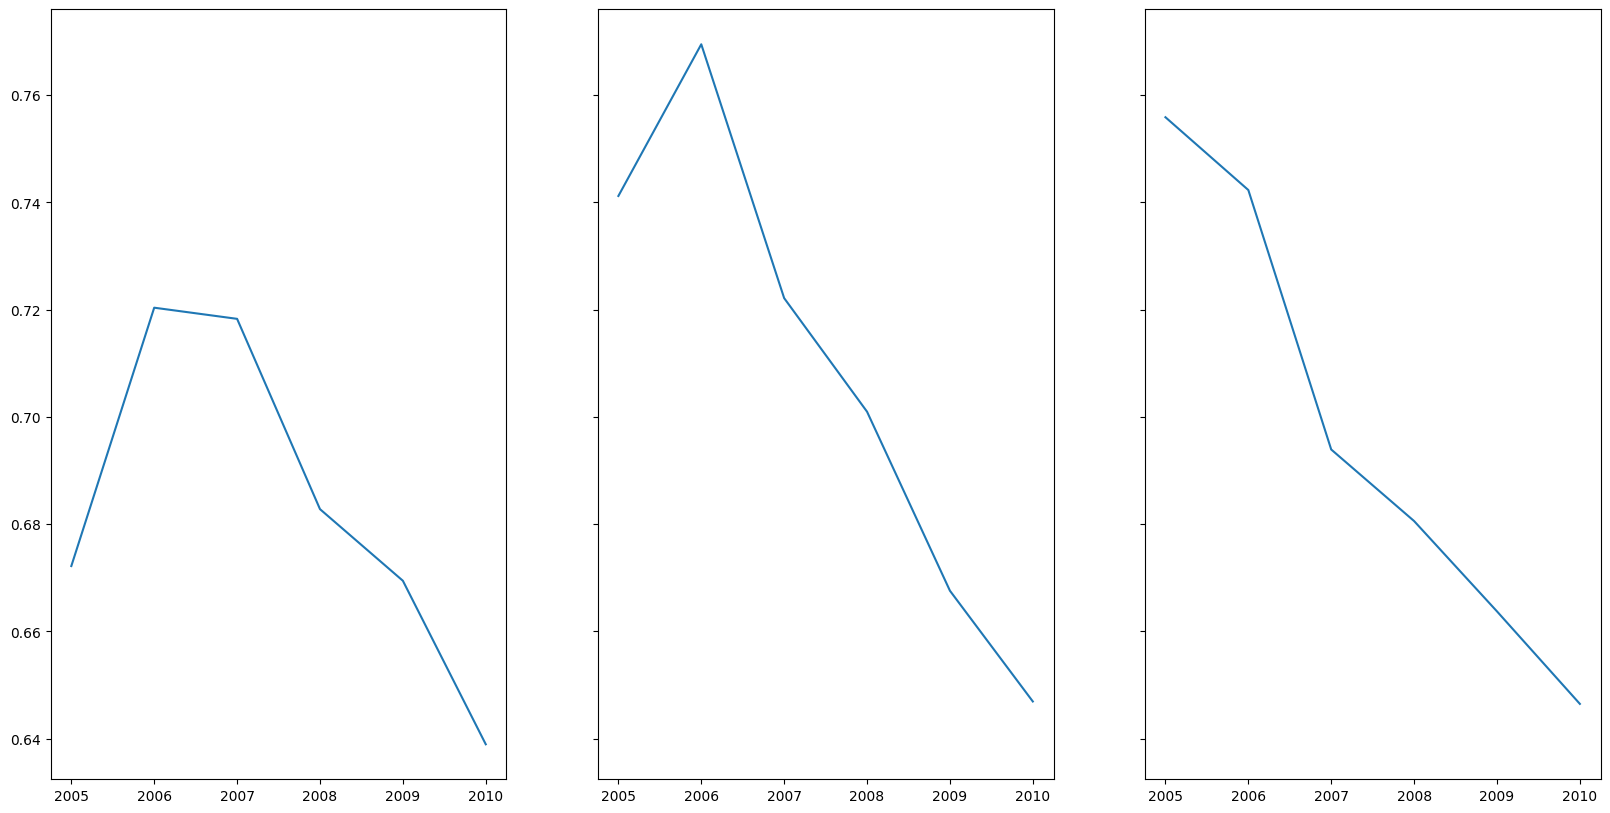

In [12]:
############# Graph 1: auROC by year 2005-2010, trained on previous 5 years' data, for nn, rf and lr 
fig, axs = plt.subplots(1,3, figsize=(4.5, 5), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')
years = np.array(range(2005, 2011))

axs[0].plot(years, ROC_by_year_nn.values())
axs[1].plot(years, ROC_by_year_lr.values())
axs[2].plot(years, ROC_by_year_rf.values())

In [53]:
########### Try functionalised 


def effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prevalence):

    get_effective_threshold = []
    incorrectly_get_X_threshold = [] #no bootstrapping, no 95% CI 
    sensitivity_threshold = []
    specificity_threshold = []
    for threshold in threshold_seq:

        y_predict_test = np.where(y_predict_proba[:, 1] > threshold, 1, 0)

        tn_test , fp_test , fn_test , tp_test  = confusion_matrix(y_true=y_test, y_pred=y_predict_test).ravel()

        sensitivity_test  = tp_test  / (tp_test   + fn_test )
        specificity_test   = tn_test / (tn_test + fp_test )

        sensitivity_threshold.append(sensitivity_test*100)
        specificity_threshold.append(specificity_test*100)
        get_effective_threshold.append(sensitivity_test * cipro_R_prevalence*100 + (100 -  cipro_R_prevalence*100)) #q_p
        incorrectly_get_X_threshold.append((100 - cipro_R_prevalence*100) * (1 - specificity_test)) #c_p"
    return(sensitivity_threshold, specificity_threshold, get_effective_threshold, incorrectly_get_X_threshold)

def get_best_hyperparameters(model, cv, space, X_train, y_train):
        search = RandomizedSearchCV(model, space, scoring='roc_auc', n_iter=1,  n_jobs=-1, cv=cv, random_state=1)
        result = search.fit(X_train, y_train)
        return(result.best_params_)

def get_best_features(feature_names, model_fit, X_test, y_test):
    PI = permutation_importance(model_fit, X_test, y_test, n_repeats = 10, random_state = 42)
    important_features = []
    for q in PI.importances_mean.argsort()[::-1]:
        if PI.importances_mean[q] - 2 * PI.importances_std[q] > 0:
          important_features.append(feature_names[q]) #works cos they are in same order as the x columns
    return(important_features)


oversample = RandomOverSampler(sampling_strategy = 0.5, random_state=42)

def get_test_train_data_overfit(CIP_data_no_drop, year, feature_names, oversample_size):
    years_train = np.array(range(year - 5, year))

    # first do for all clinics 
    train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    X_train = train_data[feature_names] #need to consider all columns BEFORE feature engineering
    y_train = 1 - train_data['Susceptible']
    X_train, y_train = oversample.fit_resample(X_train,y_train)
    #test
    test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]
    X_test = test_data[feature_names]
    y_test = 1 - test_data['Susceptible']
    cipro_R = y_test.sum()/len(y_test) 
    X_test, y_test = oversample.fit_resample(X_test,y_test)
    return(test_data, train_data, X_train, y_train, X_test, y_test, cipro_R)


def get_test_train_data(CIP_data_no_drop, year, feature_names):
    years_train = np.array(range(year - 5, year))

    CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]
    # first do for all clinics 
    train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    X_train = train_data[feature_names] #need to consider all columns BEFORE feature engineering
    y_train = 1 - train_data['Susceptible']
    #test
    test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]
    X_test = test_data[feature_names]
    y_test = 1 - test_data['Susceptible']
    return(test_data, train_data, X_train, y_train, X_test, y_test)

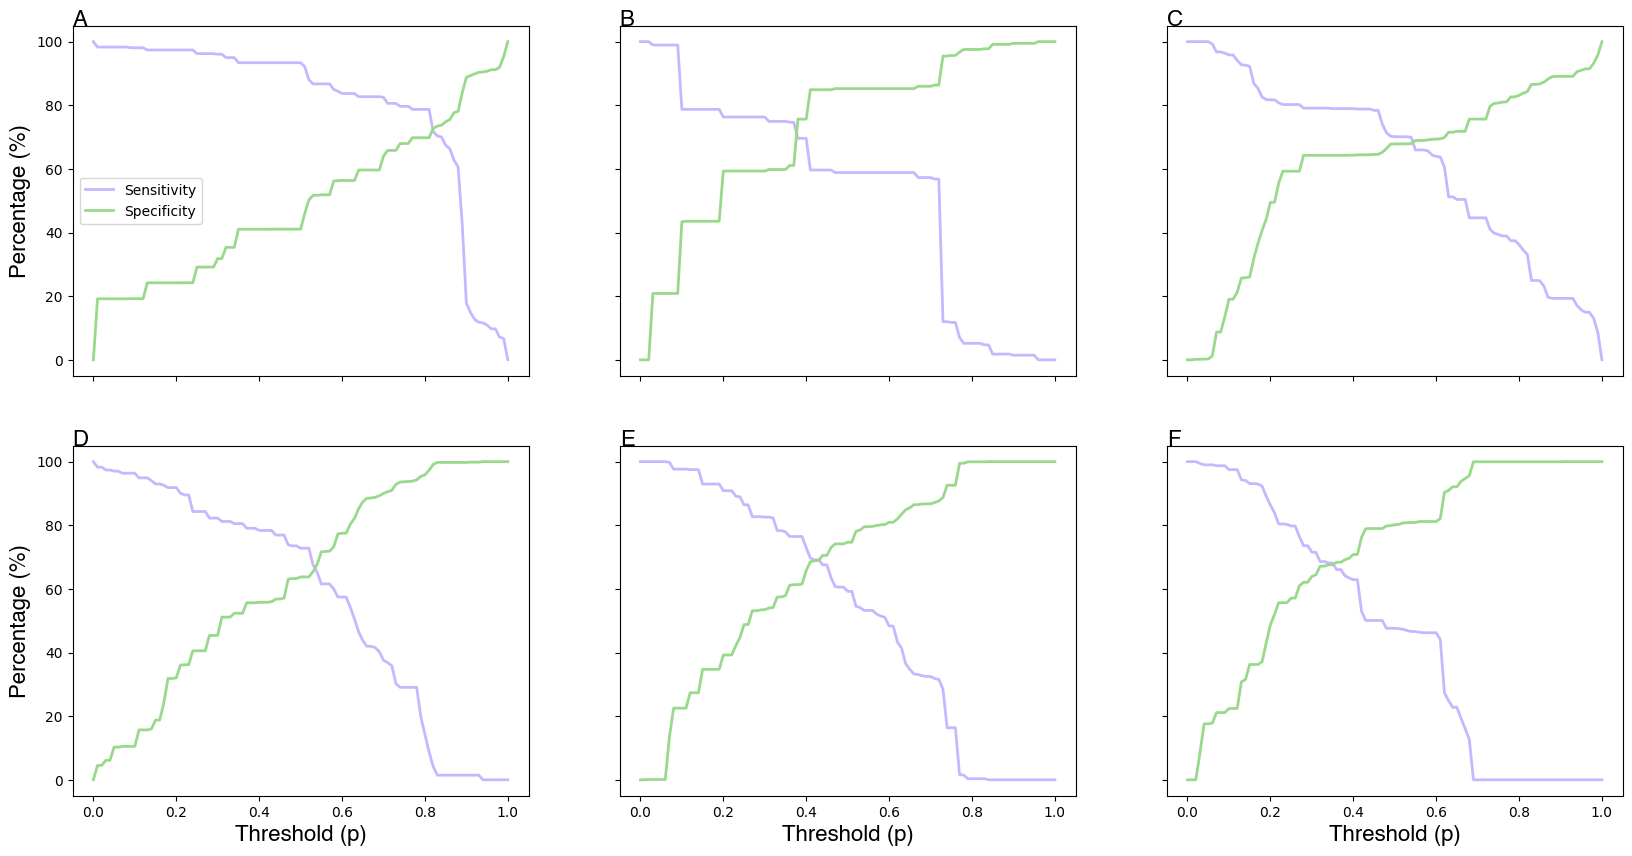

In [51]:
### Do the sensitivity by year, too... Neural network 
fig, axs = plt.subplots(2,3, figsize=(20, 10), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')
labels = ["A", "B", "C", "D", "E", "F" ]

axs[0,0].set_ylabel('Percentage (%)', fontsize=16,**hfont)
axs[1,0].set_ylabel('Percentage (%)', fontsize=16,**hfont)
axs[1,0].set_xlabel('Threshold (p)', fontsize=16,**hfont)
axs[1,1].set_xlabel('Threshold (p)', fontsize=16,**hfont)
axs[1,2].set_xlabel('Threshold (p)', fontsize=16,**hfont)

axs[0,0].set_yticks(np.linspace(0,100,6), fontsize=16,**hfont)
axs[1,0].set_yticks(np.linspace(0,100,6), fontsize=16,**hfont)
axs[1,0].set_xticks(np.linspace(0,1,6), fontsize=16,**hfont)
axs[1,1].set_xticks(np.linspace(0,1,6), fontsize=16,**hfont)
axs[1,2].set_xticks(np.linspace(0,1,6), fontsize=16,**hfont)

axs = axs.ravel()

threshold_seq = np.linspace(0,1,101)
i = 0
for year in years:
    years_train = np.array(range(year - 5, year))
    
    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev =  get_test_train_data_overfit(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year_nn[year], oversample_size = 0.5)

    model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= best_hyperparameters_by_year_nn[year]['hidden_layer_sizes'], alpha =  best_hyperparameters_by_year_nn[year]['alpha'], random_state=10, learning_rate = 'adaptive' )
    
    ## fit model
    model_fit_train = model_nn.fit(X_train, y_train)
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
    
    ## get sesnitivity and specificity
    sensitivity_threshold, specificity_threshold, get_effective_threshold, incorrectly_get_X_threshold = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)

    #plot
    axs[i].plot(threshold_seq, sensitivity_threshold, color = "#c8b6ff", label = "Sensitivity", linewidth = 2)
    axs[i].plot(threshold_seq, specificity_threshold, color = "#99d98c", label = "Specificity", linewidth = 2)
    axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 5, labels[i], fontsize = 16, **hfont)
    i += 1
axs[0].legend()
plt.tight_layout()




In [ ]:
### Do the sensitivity by year, too... logistic regression
fig, axs = plt.subplots(2,3, figsize=(4.5, 5), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')
axs[0,0].set_ylabel('Percentage (%)')
axs[1,0].set_ylabel('Percentage (%)')
axs[1,0].set_xlabel('Threshold (p)')
axs[1,1].set_xlabel('Threshold (p)')
axs[1,2].set_xlabel('Threshold (p)')

axs[0,0].set_yticks(np.linspace(0,100,6), fontsize=14,**hfont)
axs[1,0].set_yticks(np.linspace(0,100,6), fontsize=14,**hfont)
axs[1,0].set_xticks(np.linspace(0,100,6), fontsize=14,**hfont)
axs[1,1].set_xticks(np.linspace(0,100,6), fontsize=14,**hfont)
axs[1,2].set_xticks(np.linspace(0,100,6), fontsize=14,**hfont)
axs = axs.ravel()

threshold_seq = np.linspace(0,1,101)
i = 0
for year in years:
    years_train = np.array(range(year - 5, year))
    
    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year_lr[year], oversample_size = 0.5)

    model_lr = LogisticRegression(class_weight = 'balanced', max_iter=4000, solver = best_hyperparameters_by_year_lr[year]['solver'], C = best_hyperparameters_by_year_lr[year]['C'], penalty = best_hyperparameters_by_year_lr[year]['penalty'])
    
    ## fit model
    model_fit_train = model_lr.fit(X_train, y_train)
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
    
    ## get sesnitivity and specificity
    sensitivity_threshold, specificity_threshold, get_effective_threshold, incorrectly_get_X_threshold = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)

    #plot
    axs[i].plot(threshold_seq, sensitivity_test_threshold, color = "#c8b6ff", label = "Sensitivity", linewidth = 2)
    axs[i].plot(threshold_seq, specificity_test_threshold, color = "#99d98c", label = "Specificity", linewidth = 2)
    axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 5, labels[i], fontsize = 16, **hfont)
    i += 1

axs[0].legend()



In [ ]:
### Do the sensitivity by year, too... random forest 

### Do the sensitivity by year, too... logistic regression
fig, axs = plt.subplots(2,3, figsize=(4.5, 5), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')
axs[0,0].set_ylabel('Percentage (%)')
axs[1,0].set_ylabel('Percentage (%)')
axs[1,0].set_xlabel('Threshold (p)')
axs[1,1].set_xlabel('Threshold (p)')
axs[1,2].set_xlabel('Threshold (p)')

axs[0,0].set_yticks(np.linspace(0,100,6), fontsize=14,**hfont)
axs[1,0].set_yticks(np.linspace(0,100,6), fontsize=14,**hfont)
axs[1,0].set_xticks(np.linspace(0,1,6), fontsize=14,**hfont)
axs[1,1].set_xticks(np.linspace(0,1,6), fontsize=14,**hfont)
axs[1,2].set_xticks(np.linspace(0,1,6), fontsize=14,**hfont)
axs = axs.ravel()

threshold_seq = np.linspace(0,1,101)
i = 0
for year in years:
    years_train = np.array(range(year - 5, year))
    
    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev =  get_test_train_data_overfit(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year_rf[year], oversample_size = 0.5)

    model_rf = RandomForestClassifier(n_estimators = best_hyperparameters_by_year_rf[year]['n_estimators'], min_samples_split = best_hyperparameters_by_year_rf[year]['min_samples_split'], min_samples_leaf=best_hyperparameters_by_year_rf[year]['min_samples_leaf'], max_features = 'sqrt', max_depth = best_hyperparameters_by_year_rf[year]['max_depth'], random_state = 10)
    
    ## fit model
    model_fit_train = model_rf.fit(X_train, y_train)
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
    
    ## get sesnitivity and specificity
    sensitivity_threshold, specificity_threshold, get_effective_threshold, incorrectly_get_X_threshold = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)

    #plot
    axs[i].plot(threshold_seq, sensitivity_test_threshold, color = "#c8b6ff", label = "Sensitivity", linewidth = 2)
    axs[i].plot(threshold_seq, specificity_test_threshold, color = "#99d98c", label = "Specificity", linewidth = 2)
    axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 5, labels[i], fontsize = 16, **hfont)
    i += 1
axs[0].legend()



In [59]:
###### Effect of threshold on year-by-year for random forest model 

fig, axs = plt.subplots(2,3, figsize=(20, 10), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')
text_for_graph = ['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1']
indices = [0,10,20,30,40,50,60,70,80,90,100]

axs[0,0].set_ylabel('Unnecessarily received dual therapy (%) ($\omega$(p))')
axs[1,0].set_ylabel('Unnecessarily received dual therapy (%) ($\omega$(p))')
axs[1,0].set_xlabel('Received effective treatment (%) ($\theta$(p))')
axs[1,1].set_xlabel('Received effective treatment (%) ($\theta$(p))')
axs[1,2].set_xlabel('Received effective treatment (%) ($\theta$(p))')

axs[0,0].set_yticks(np.linspace(0,100,6), fontsize=14,**hfont)
axs[1,0].set_yticks(np.linspace(0,100,6), fontsize=14,**hfont)
axs[1,0].set_xticks(np.linspace(0,100,6), fontsize=14,**hfont)
axs[1,1].set_xticks(np.linspace(0,100,6), fontsize=14,**hfont)
axs[1,2].set_xticks(np.linspace(0,100,6), fontsize=14,**hfont)
axs = axs.ravel()

threshold_seq = np.linspace(0,1,101)

i = 0
for year in years:
    years_train = np.array(range(year - 5, year))
    
    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev =  get_test_train_data_overfit(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year_rf[year], oversample_size = 0.5)

    model_rf = RandomForestClassifier(n_estimators = best_hyperparameters_by_year_rf[year]['n_estimators'], min_samples_split = best_hyperparameters_by_year_rf[year]['min_samples_split'], min_samples_leaf=best_hyperparameters_by_year_rf[year]['min_samples_leaf'], max_features = 'sqrt', max_depth = best_hyperparameters_by_year_rf[year]['max_depth'], random_state = 10)
    
    ## fit model
    model_fit_train = model_rf.fit(X_train, y_train)
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
    
    ## get sesnitivity and specificity
    sensitivity_threshold, specificity_threshold, get_effective_threshold, incorrectly_get_X_threshold = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)

    #plot
    axs[i].plot(get_effective_threshold, incorrectly_get_X_threshold, color = "black", linewidth = 3)
    axs[i].plot(100, (1 - cipro_R_prev)*100, marker='s', ls='none', ms=16, color = "black", label = "Dual")
    axs[i].plot((1-cipro_R_prev)*100, 0, marker='*', ls='none', ms=14, color = "black", label = "Cipro")
    axs[i].plot([100, (1-cipro_R_prev)*100], [(1-cipro_R_prev)*100, 0], color = "#808080", linestyle="--")
    axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 5, labels[i], fontsize = 16, **hfont)
    x = 0
    for index in indices:
        axs[i].plot(get_effective_threshold[index], incorrectly_get_X_threshold[index], marker='.', ls='none', ms=11, color = "#b56576")
    if get_effective_threshold[index] > 0.996:
        axs[i].text(get_effective_threshold[index] + 0.001, incorrectly_get_X_threshold[index] - 0.001, text_for_graph[x], size = 9)
    elif (get_effective_threshold[index] > 0.9) & (get_effective_threshold[index] < 0.996):
        axs[i].text(get_effective_threshold[index] + 0.005, incorrectly_get_X_threshold[index] - 0.005, text_for_graph[x], size = 9)
    else:
        axs[i].text(get_effective_threshold[index], incorrectly_get_X_threshold[index] + 0.025, text_for_graph[x], size = 9)
    x = x+1
    i += 1

axs[0].legend()



In [40]:

############# why does it decrease over time??? 
space = dict()
space['activation'] = ['tanh', 'relu']
space['alpha'] = np.logspace(-1, 1, 10)
#space['learning_rate'] = ['constant','adaptive']
space['hidden_layer_sizes'] = [(12), (13), (14)]

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=10)
model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= 12, alpha =  1.29, random_state=10, learning_rate = 'adaptive' )

train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2004, 2005, 2006, 2007, 2008])]
X_train = train_data[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
y_train = 1 - train_data['Susceptible']

oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
X, y = oversample.fit_resample(X_train,y_train)
model_fit = model_nn.fit(X_train,y_train)

search = RandomizedSearchCV(model_nn, space, scoring='roc_auc', n_jobs=-1, cv=cv, random_state=1)
result = search.fit(X_train,y_train)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)
#2010 {'hidden_layer_sizes': 14, 'alpha': 0.1, 'activation': 'tanh'} different to what came from loop...

Best Score: 0.824477493687889
Best Hyperparameters: {'hidden_layer_sizes': 14, 'alpha': 0.1, 'activation': 'tanh'}


In [43]:
model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= 14, alpha =  0.1, random_state=10, learning_rate = 'adaptive' )

train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2005, 2006, 2007, 2008, 2009])]
X_train = train_data[best_features_by_year_nn[2010]]
y_train = 1 - train_data['Susceptible']
X_train, y_train = oversample.fit_resample(X_train,y_train)

test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2010])]

X_test = test_data[best_features_by_year_nn[2010]]
y_test = 1 - test_data['Susceptible']
X_test, y_test = oversample.fit_resample(X_test,y_test)
model_fit_train = model_nn.fit(X_train, y_train)

  #2. Test model on test data to get test specificity and sensitivity 
  
y_predict = model_fit_train.predict(X_test)
y_predict_proba = model_fit_train.predict_proba(X_test)

ROC_AUC_nn_2010= metrics.roc_auc_score(y_test, y_predict)

print(ROC_AUC_nn_2010)


0.6463855421686747


/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:536: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [38]:
print(best_features_by_year_nn[2010])

['PREV_REGION', 'MSM', 'MSW', 'West', 'Southeast', 'MSMW', 'Northeast', 'Southwest', 'Midwest', 'PREV_CLINIC', 'DELTA_REGION', 'Oth/Unk/Missing']
